In [1]:
!git clone https://bitbucket.org/turtleshelltechnologies/snoring

Cloning into 'snoring'...
remote: Counting objects: 27, done.
remote: Compressing objects: 100% (26/26), done.
remote: Total 27 (delta 11), reused 0 (delta 0)
Unpacking objects: 100% (27/27), done.


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import librosa
import librosa.display

from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier

(20000, 1)


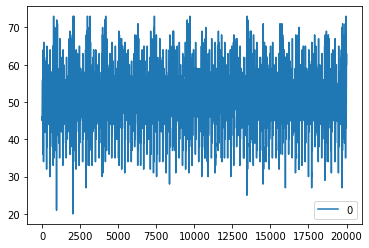

In [3]:
telemetry = pd.read_csv("../input/testdata1/data1.csv", header=None, squeeze=False)[:20_000]
print(telemetry.shape)
telemetry.plot()

telemetry2 = pd.read_csv("../input/testdata3/data3.csv", header=None, squeeze=False)
# telemetry2.plot()

In [4]:

def calc_stft_feats(telemetry):
    S = librosa.core.stft(telemetry.values.reshape(-1).astype(np.float), 
                      n_fft=128, 
                      hop_length=1,
                      win_length=100)
    spect_db = librosa.amplitude_to_db(S, ref=np.max)
    return spect_db

def plot_stft(telemetry):
    
    spect_db = calc_stft_feats(telemetry)

    fig, ax = plt.subplots(figsize=(24, 12))
    img = librosa.display.specshow(spect_db, y_axis='log', ax=ax)
    ax.set_title('Power spectrogram')
    fig.colorbar(img, ax=ax, format="%+2.0f dB")
    
# plot_stft(telemetry)

In [5]:
S = librosa.core.stft(telemetry.values.reshape(-1).astype(np.float), 
                      n_fft=128, 
                      hop_length=1,
                      win_length=100)

In [6]:
# fig, ax = plt.subplots(figsize=(24, 12))
# img = librosa.display.specshow(S, y_axis='log', ax=ax)
# ax.set_title('Power spectrogram')
# fig.colorbar(img, ax=ax, format="%+2.0f dB")

In [7]:
spect_db = calc_stft_feats(telemetry)
spect_db.shape

/opt/conda/lib/python3.7/site-packages/librosa/core/spectrum.py:1642: UserWarning: amplitude_to_db was called on complex input so phase information will be discarded. To suppress this warning, call amplitude_to_db(np.abs(S)) instead.
  "amplitude_to_db was called on complex input so phase "


(65, 20001)

In [8]:
feats_touse_index = spect_db.var(1) > 10

In [9]:
TIME_STEPS = 32

# Generated training sequences for use in the model.
def create_sequences(values, time_steps=TIME_STEPS):
    output = []
    for i in range(len(values) - time_steps):
        output.append(values[i : (i + time_steps)])
    return np.stack(output)


x_train = create_sequences(spect_db.transpose()[:,feats_touse_index])
print("Training input shape: ", x_train.shape)

Training input shape:  (19969, 32, 62)


(array([0, 1], dtype=int32), array([11552,  8449]))


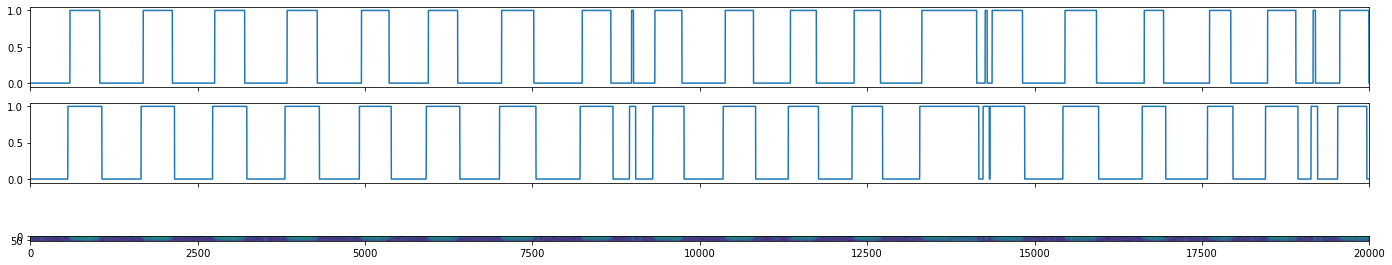

In [10]:

np.random.seed(1291295)
km = KMeans(n_clusters=2)
# # centers = km.fit_transform(x_train_encodings)
km.fit_transform(spect_db.transpose())
cluster_ids = pd.Series(km.labels_).rolling(20*4, center=True).quantile(0.9).fillna(0)

print(np.unique(km.labels_, return_counts=True))

fig, ax = plt.subplots(3,1,figsize=(24, 5), sharex=True)
plt.imshow(spect_db)
ax[0].plot(km.labels_)
ax[1].plot(cluster_ids)

plt.show()

In [11]:
y_train = cluster_ids[:len(x_train)]

In [12]:
def get_classifier():
    clf = RandomForestClassifier(n_estimators=10)
    return clf
clf = get_classifier()
clf.fit(x_train.reshape(len(x_train), -1), y_train.astype(int))

RandomForestClassifier(n_estimators=10)

In [13]:
clf.score(x_train.reshape(len(x_train), -1), y_train.astype(int))

0.9997496118984426

In [14]:
spect_db2 = calc_stft_feats(telemetry2)
# Create sequences from test values.
x_test = create_sequences(spect_db2.transpose()[:,feats_touse_index])
print("Test input shape: ", x_test.shape)

/opt/conda/lib/python3.7/site-packages/librosa/core/spectrum.py:1642: UserWarning: amplitude_to_db was called on complex input so phase information will be discarded. To suppress this warning, call amplitude_to_db(np.abs(S)) instead.
  "amplitude_to_db was called on complex input so phase "


Test input shape:  (59963, 32, 62)


In [15]:
x_test_pred = clf.predict(x_test.reshape(len(x_test), -1))
# x_test_pred = np.abs(x_test_pred-1)

x_test_pred_smooth = pd.Series(x_test_pred).rolling(20*4, center=True).quantile(0.9).fillna(0)

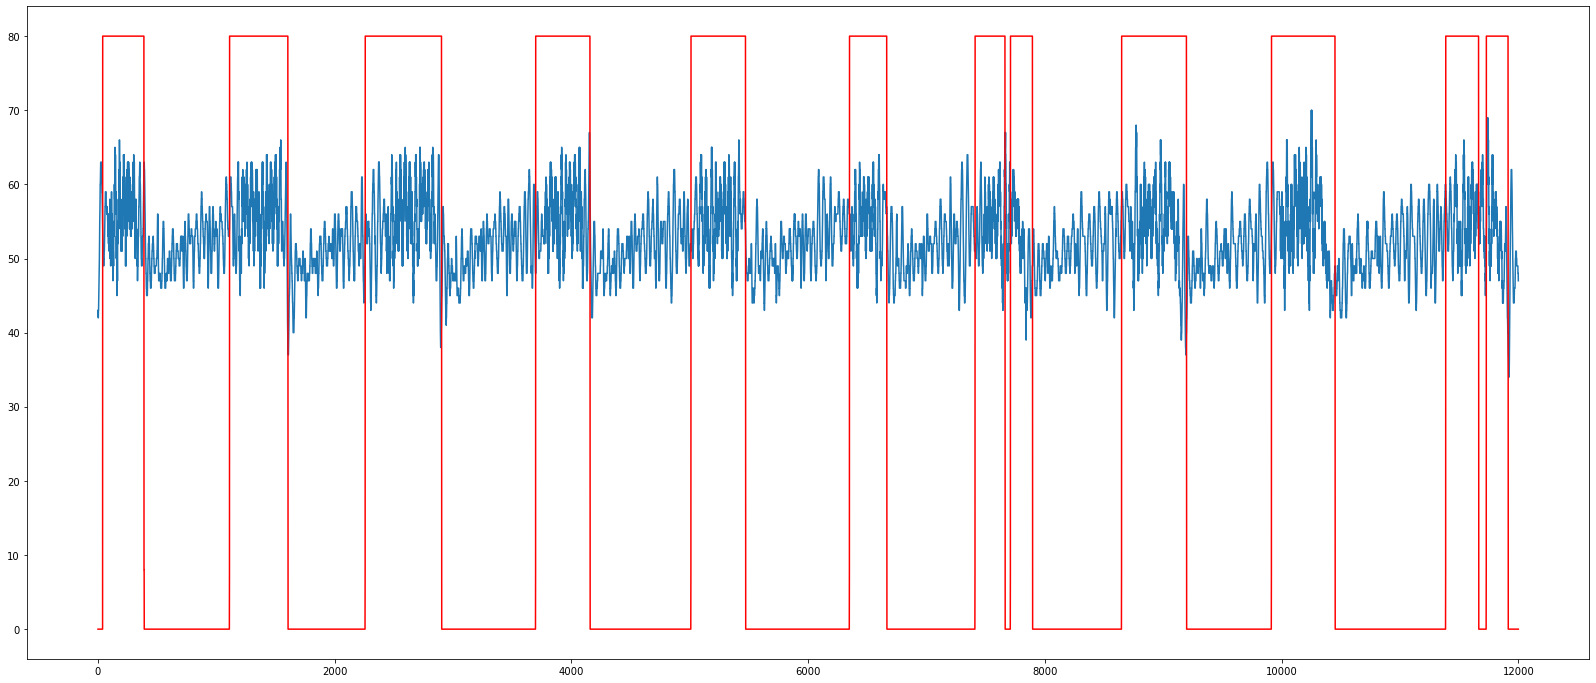

In [16]:
fig, ax = plt.subplots(figsize=(28,12))
telemetry2[:12_000].plot(legend=False, ax=ax)
plt.plot(x_test_pred_smooth[:12_000]*80, "-r")
plt.show()